In [1]:
%load_ext autoreload
%autoreload 2

In [75]:
import os
import sys
import random

import cv2
import numpy as np
import pandas as pd
import h5py

import keras
from keras import models
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn

from PIL import Image, ImageColor, ImageDraw, ImageStat

sys.path.append("..") 
from train import plot_history

In [76]:
class_names = {0: 'alien',
                 1: 'devil',
                 2: 'ghost',
                 3: 'hearteyes',
                 4: 'lipstick',
                 5: 'octopus',
                 6: 'poop',
                 7: 'robot',
                 8: 'rocket',
                 9: 'unicorn'}

In [85]:
# h5_file = '../output-aws/tenclasses-augm/simple_cnn_multi_10c_with_aug.h5'
# hdf5_file = '../output-aws/tenclasses-augm/hdf5/simple_cnn_multi-071-0.163.hdf5'

h5_file = '../output-aws/fiveclasses-augm/simple_cnn_multi_5c_with_aug.h5'
hdf5_file = '../output-aws/fiveclasses-augm/hdf5/simple_cnn_multi-099-0.079.hdf5'

def load_model_and_weights(h5_file, hdf5_file):
    model = models.load_model(h5_file)
    model.load_weights(hdf5_file)
    
    return model

model = load_model_and_weights(h5_file, hdf5_file)

/Users/koshkin/miniconda3/lib/python3.6/site-packages/keras/models.py:288: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [86]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 318, 238, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 159, 119, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 157, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 78, 58, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 76, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 38, 28, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 26, 128)       147584    
__________

In [141]:
def pick_random_test_image():
    global class_names
#     label = class_names.get(random.randint(0, 5))
    label = class_names.get(2)
    path = os.path.join('../images/five_multiclass/test', label)
    fname = random.choice(os.listdir(path))
    return os.path.join(path, fname)

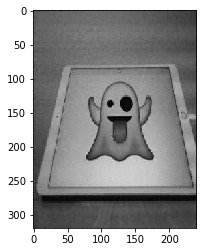

In [156]:
img_path = pick_random_test_image()

img = load_img(img_path, target_size=(320, 240))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)


img_tensor /= 255.  

plt.imshow(img_tensor[0]);

In [157]:
img_path

'../images/five_multiclass/test/ghost/ghost-261.jpeg'

In [324]:
layer_outputs = [layer.output for layer in model.layers[:8]]

activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 318, 238, 32)


### It’s a 318 × 238 feature map with 32 channels.

In [325]:
import seaborn as sns

In [326]:
def plotNNFilter(units, k):
    filters = units.shape[3]
    n_columns = 16
    plt.figure(1, figsize=(15,filters//n_columns))
    
    n_rows = np.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1, xticks=[], yticks=[])
#         plt.title('f ' + str(i))
        plt.annotate(f'{str(i)}', fontsize=10, fontweight='bold', xy=(0,k), color='lightgray') 
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="viridis")
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.05, hspace=0.05)
        

In [327]:
len(activations)

8

In [328]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(15,12))
    n_columns = 8
    n_rows = np.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1, xticks=[], yticks=[])
#         plt.title('f ' + str(i))
        plt.annotate(f'{str(i)}', fontsize=10, fontweight='bold', xy=(0,20), color='lightgray') 
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="viridis")
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.05, hspace=0.05)
        


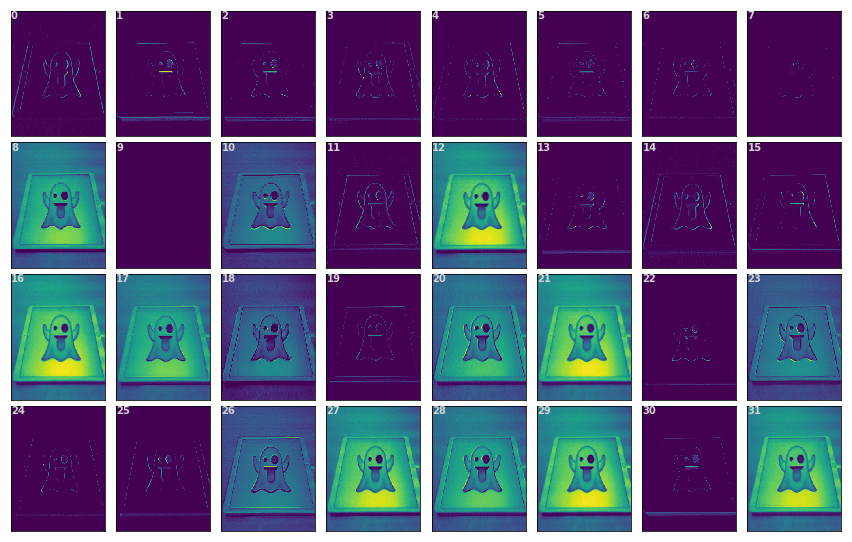

In [329]:
plotNNFilter(activations[-8])

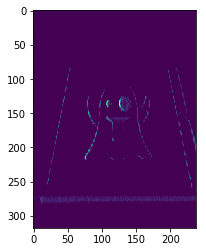

In [336]:
image = first_layer_activation[0, :, :, 25][:]
image = np.maximum(image, 0)
plt.imshow(image, cmap='viridis')

In [315]:
first_layer_activation[0, :, :, 25]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01775489, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03042632, 0.00012445, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01209794, 0.00047782, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

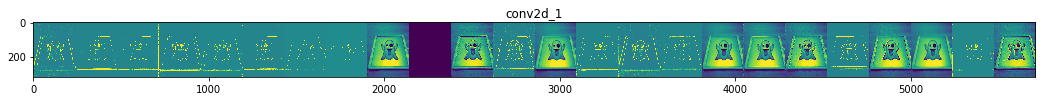

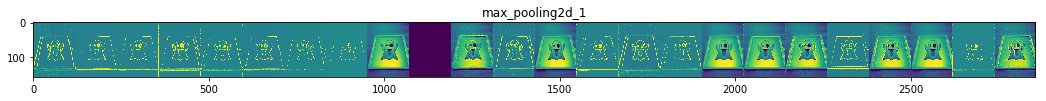

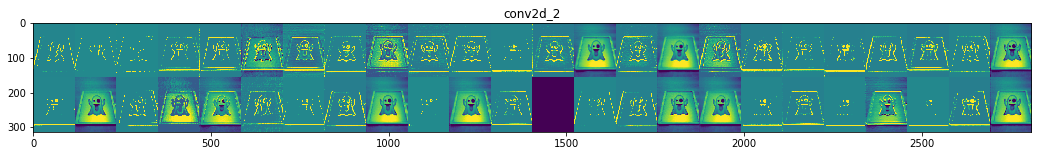

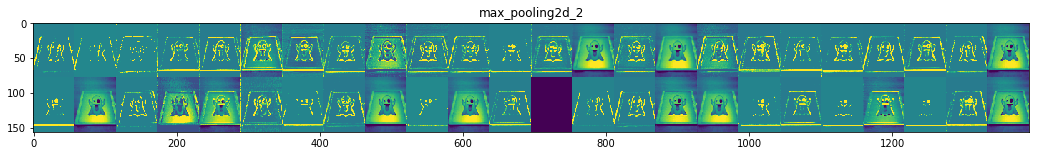

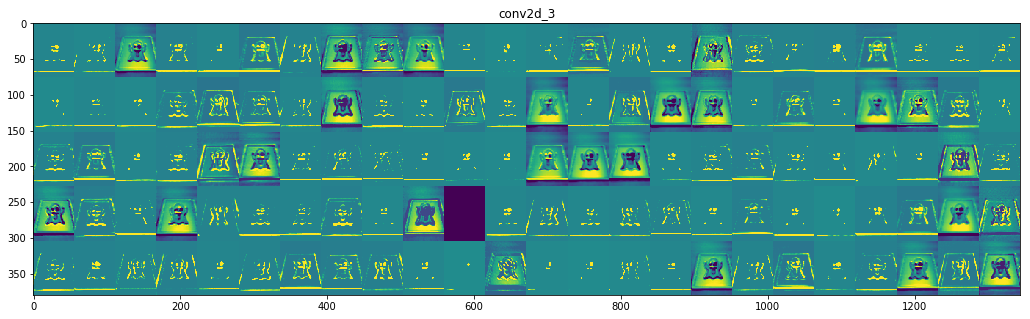

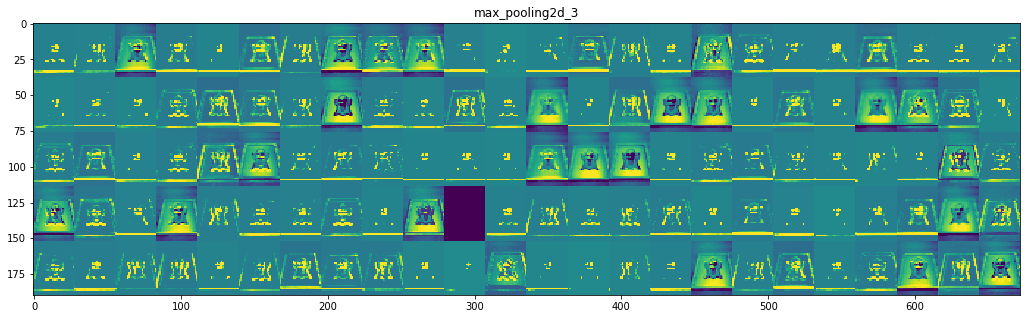

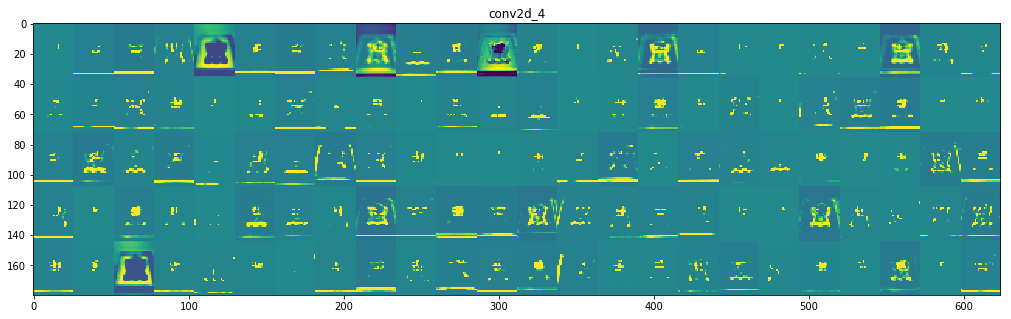

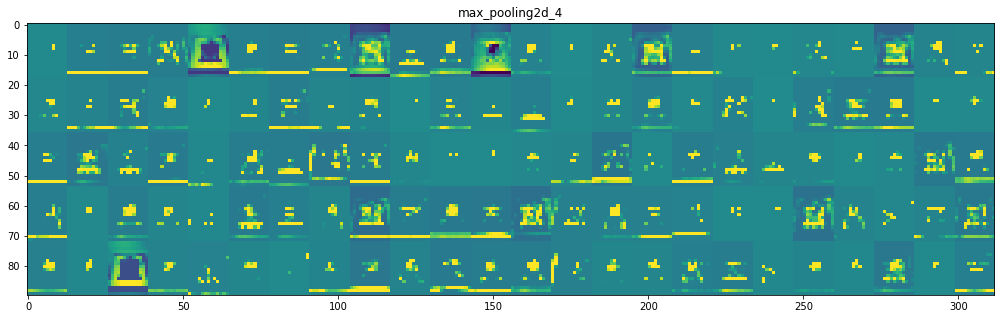

In [264]:
layer_names = []                                                          
for layer in model.layers[:8]:                                            
    layer_names.append(layer.name)                                        

images_per_row = 24

for layer_name, layer_activation in zip(layer_names, activations):        
    n_features = layer_activation.shape[-1]                               

    size = layer_activation.shape[1]      
    size2 = layer_activation.shape[2]

    n_cols = n_features // images_per_row                                 
    display_grid = np.zeros((size * n_cols, images_per_row * size2))

    for col in range(n_cols):                                             
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()                         
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,                   
                         row * size2 : (row + 1) * size2] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.imshow(display_grid, aspect='auto',interpolation="nearest", cmap='viridis')
#     fname = f'{layer_name}.jpeg'
#     plt.imsave(fname, display_grid)

### There are a few things to note here:

* The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
* As you go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
* The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank. **This means the pattern encoded by the filter isn’t found in the input image**.

In [172]:
x = img_tensor
#: Visualize what part of the image is the most 'robot' (or 'unicorn' etc.)

#: get class for the given image
preds = model.predict_classes(x)
probs = model.predict(x)

print('{0}: {1:0.2}'.format(class_names.get(preds[0]), probs.max()))


ghost: 1.0


ValueError: slice index 5 of dimension 1 out of bounds. for 'strided_slice_280' (op: 'StridedSlice') with input shapes: [?,5], [2], [2], [2] and with computed input tensors: input[1] = <0 5>, input[2] = <0 6>, input[3] = <1 1>.

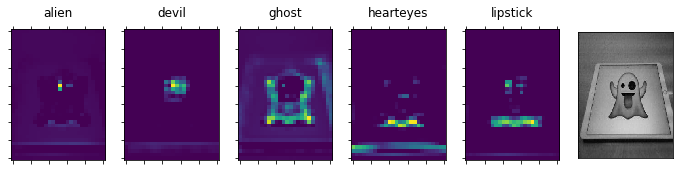

In [173]:
fig = plt.figure(figsize=(20,5))

class_names = {0: 'alien',
                 1: 'devil',
                 2: 'ghost',
                 3: 'hearteyes',
                 4: 'lipstick',
                 5: 'octopus',
                 6: 'poop',
                 7: 'robot',
                 8: 'rocket',
                 9: 'unicorn'}

for i in range(10):
    
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    
    #: get robot/unicorn etc element in prediction vector
#     emoji_output = model.output[:,preds[0]]
    emoji_output = model.output[:,i]

    last_conv_layer = model.get_layer('conv2d_4')

    #: gradient of emoji class with output feature map of last conv layer
    grads = K.gradients(emoji_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    #: get values of pooled_grad and last_conv_layer output feature map
    iterate = K.function([model.input],
                         [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([x])

    #: Multiplies each channel in the feature-map array by 
    #: “how important this channel is” with regard to the #emoji class
    for f in range(128):
        conv_layer_output_value[:, :, f] *= pooled_grads_value[f]

    heatmap = np.mean(conv_layer_output_value, axis=-1) 
    
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    ax.set_title(class_names.get(i))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.matshow(heatmap)

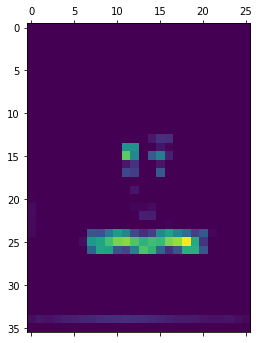

In [186]:
#: get robot/unicorn etc element in prediction vector
# emoji_output = model.output[:,preds[0]]
emoji_output = model.output[:,4]

last_conv_layer = model.get_layer('conv2d_4')

#: gradient of emoji class with output feature map of last conv layer
grads = K.gradients(emoji_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

#: get values of pooled_grad and last_conv_layer output feature map
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

#: Multiplies each channel in the feature-map array by 
#: “how important this channel is” with regard to the #emoji class
for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1) 

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

class_names = {0: 'alien',
                 1: 'devil',
                 2: 'ghost',
                 3: 'hearteyes',
                 4: 'lipstick',
                 5: 'octopus',
                 6: 'poop',
                 7: 'robot',
                 8: 'rocket',
                 9: 'unicorn'}

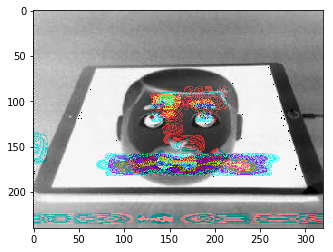

In [187]:
img_path = '/Users/koshkin/Documents/g/capstone/cozmo-emoji-bingo/images/five_multiclass/test/human/human-10.jpeg'
# img_path = '/Users/koshkin/Documents/g/capstone/cozmo-emoji-bingo/images/five_multiclass/test/devil/devil-16.jpeg'
# img_path = '/Users/koshkin/Documents/g/capstone/cozmo-emoji-bingo/images/five_multiclass/test/devil/human-10.jpeg'
img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

dst_path = os.path.basename(img_path)
cv2.imwrite(dst_path, superimposed_img)
plt.imshow(superimposed_img)

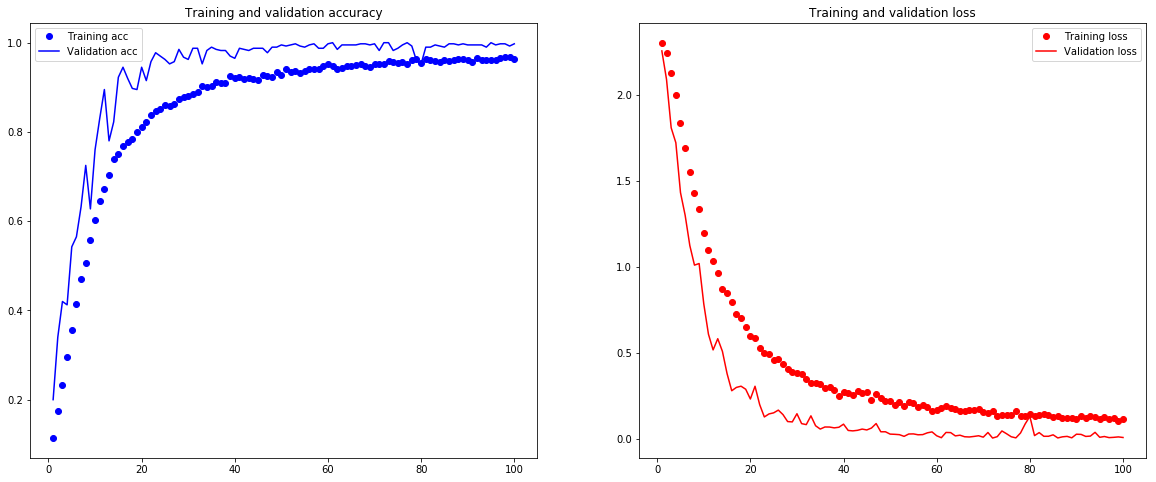

In [10]:
history = '../output-aws/tenclasses-augm/logs/history_hist_simple_cnn_multi_10c_with_aug.csv'
dfh = pd.read_csv(history)
plot_history(dfh)

In [12]:
test_dir = '../images/ten_multiclass/test/'
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(320, 240),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 10 classes.
test acc: 0.9969999992847443


In [11]:
from sklearn.metrics import classification_report

In [16]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir,
    target_size=(320, 240),
    batch_size=12,
    class_mode='categorical',
    shuffle=False)

test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1) 

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())    

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

Found 1000 images belonging to 10 classes.
             precision    recall  f1-score   support

      alien       1.00      0.84      0.91       100
      devil       0.86      0.99      0.92       100
      ghost       0.96      1.00      0.98       100
  hearteyes       1.00      0.68      0.81       100
   lipstick       0.99      0.97      0.98       100
    octopus       1.00      0.86      0.92       100
       poop       0.96      1.00      0.98       100
      robot       0.75      1.00      0.85       100
     rocket       0.94      0.92      0.93       100
    unicorn       0.92      1.00      0.96       100

avg / total       0.94      0.93      0.92      1000



In [95]:
from keras.utils import plot_model  

In [97]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)  